In [2]:
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.features import rasterize

import pandas as pd
import geopandas as geopd

import numpy as np
import numpy.ma as ma

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [3]:
max_seg_length = 4000

src_path = f"/home/iiro/Documents/DIWA/data/hydrology_iiro/subwatersheds_steepness{max_seg_length}.gpkg"
dst_path = f"/home/iiro/Documents/DIWA/data/hydrology_iiro/subwatersheds_{max_seg_length}.gpkg"
dem_path = "/media/iiro/T9/gisT7/korkeusmalli_10_m/korkeusmalli_10_m.vrt"

vector_watershed_path = "/home/iiro/Documents/DIWA/data/hydrology_iiro/watersheds.gpkg"
watersheds = geopd.read_file(vector_watershed_path, layer='watersheds')

In [5]:
test_selection =50

pbar = tqdm(watersheds.iterrows(), total=len(watersheds))

for i, watershed in pbar:
    #if i < test_selection:
        #continue

    #Changing to GeoDataFrame
    watershed = geopd.GeoDataFrame(
                    dict(zip(list(watershed.index), list(watershed.values))),
                    crs=watersheds.crs, geometry='geometry', index=[0])

    place_id = watershed.at[0, 'Paikka_Id']

    subwatersheds = geopd.read_file(src_path, layer=f"subwatersheds_{place_id}")

    
    
    
    for j, subwatershed in subwatersheds.iterrows():

        subwatershed = geopd.GeoDataFrame(
                dict(zip(list(subwatershed.index), list(subwatershed.values))),
                crs=subwatersheds.crs, geometry='geometry', index=[0])

        minx = subwatershed.bounds.at[0, 'minx']
        miny = subwatershed.bounds.at[0, 'miny']
        maxx = subwatershed.bounds.at[0, 'maxx']
        maxy = subwatershed.bounds.at[0, 'maxy']

        # Opening window of the data from the area of the watershed    
        with rasterio.open(dem_path) as src:
            profile = src.profile
            values = src.read(
                1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                boundless=True, fill_value=profile['nodata'])
        
        profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
        profile['width'] = values.shape[1]
        profile['height'] = values.shape[0]
    
        # Nodata and waters are excluded so that they don't interfere
        masked_values = ma.masked_values(values, profile['nodata'])

        
        area_mask = rasterize(
                subwatershed['geometry'], (profile['height'], profile['width']),
                dtype=profile['dtype'], transform=profile['transform'], all_touched=True)

        # When calculating the average, unwanted regions must be masked
        clipped_values = ma.masked_where(area_mask == 0, masked_values)

        # Masked arrays are not supported by percentiles in the numpuy version I am using ('1.26.4'), thus the nodata values are changed to nan
        clipped_values = ma.filled(clipped_values, np.nan)

        """
        Calculating elevation descriptors
        """
        # Mean
        subwatersheds.at[j, 'elev_mean'] = np.nanmean(clipped_values)
        # Minimum
        subwatersheds.at[j, 'elev_min'] = np.nanmin(clipped_values)
        # 10th percentile
        subwatersheds.at[j, 'elev_10'] = np.nanpercentile(clipped_values, 10)
        # median
        subwatersheds.at[j, 'elev_50'] = np.nanpercentile(clipped_values, 50)
        # 90 th percentile
        subwatersheds.at[j, 'elev_90'] = np.nanpercentile(clipped_values, 90)
        # Maximum
        subwatersheds.at[j, 'elev_max'] = np.nanmax(clipped_values)
        
    subwatersheds['elev_range'] =  subwatersheds['elev_max'] - subwatersheds['elev_min']
    subwatersheds.to_file(dst_path, layer=f"subwatersheds_{place_id}", driver="GPKG")
    #if i == test_selection:
        #break

  0%|          | 0/167 [00:00<?, ?it/s]

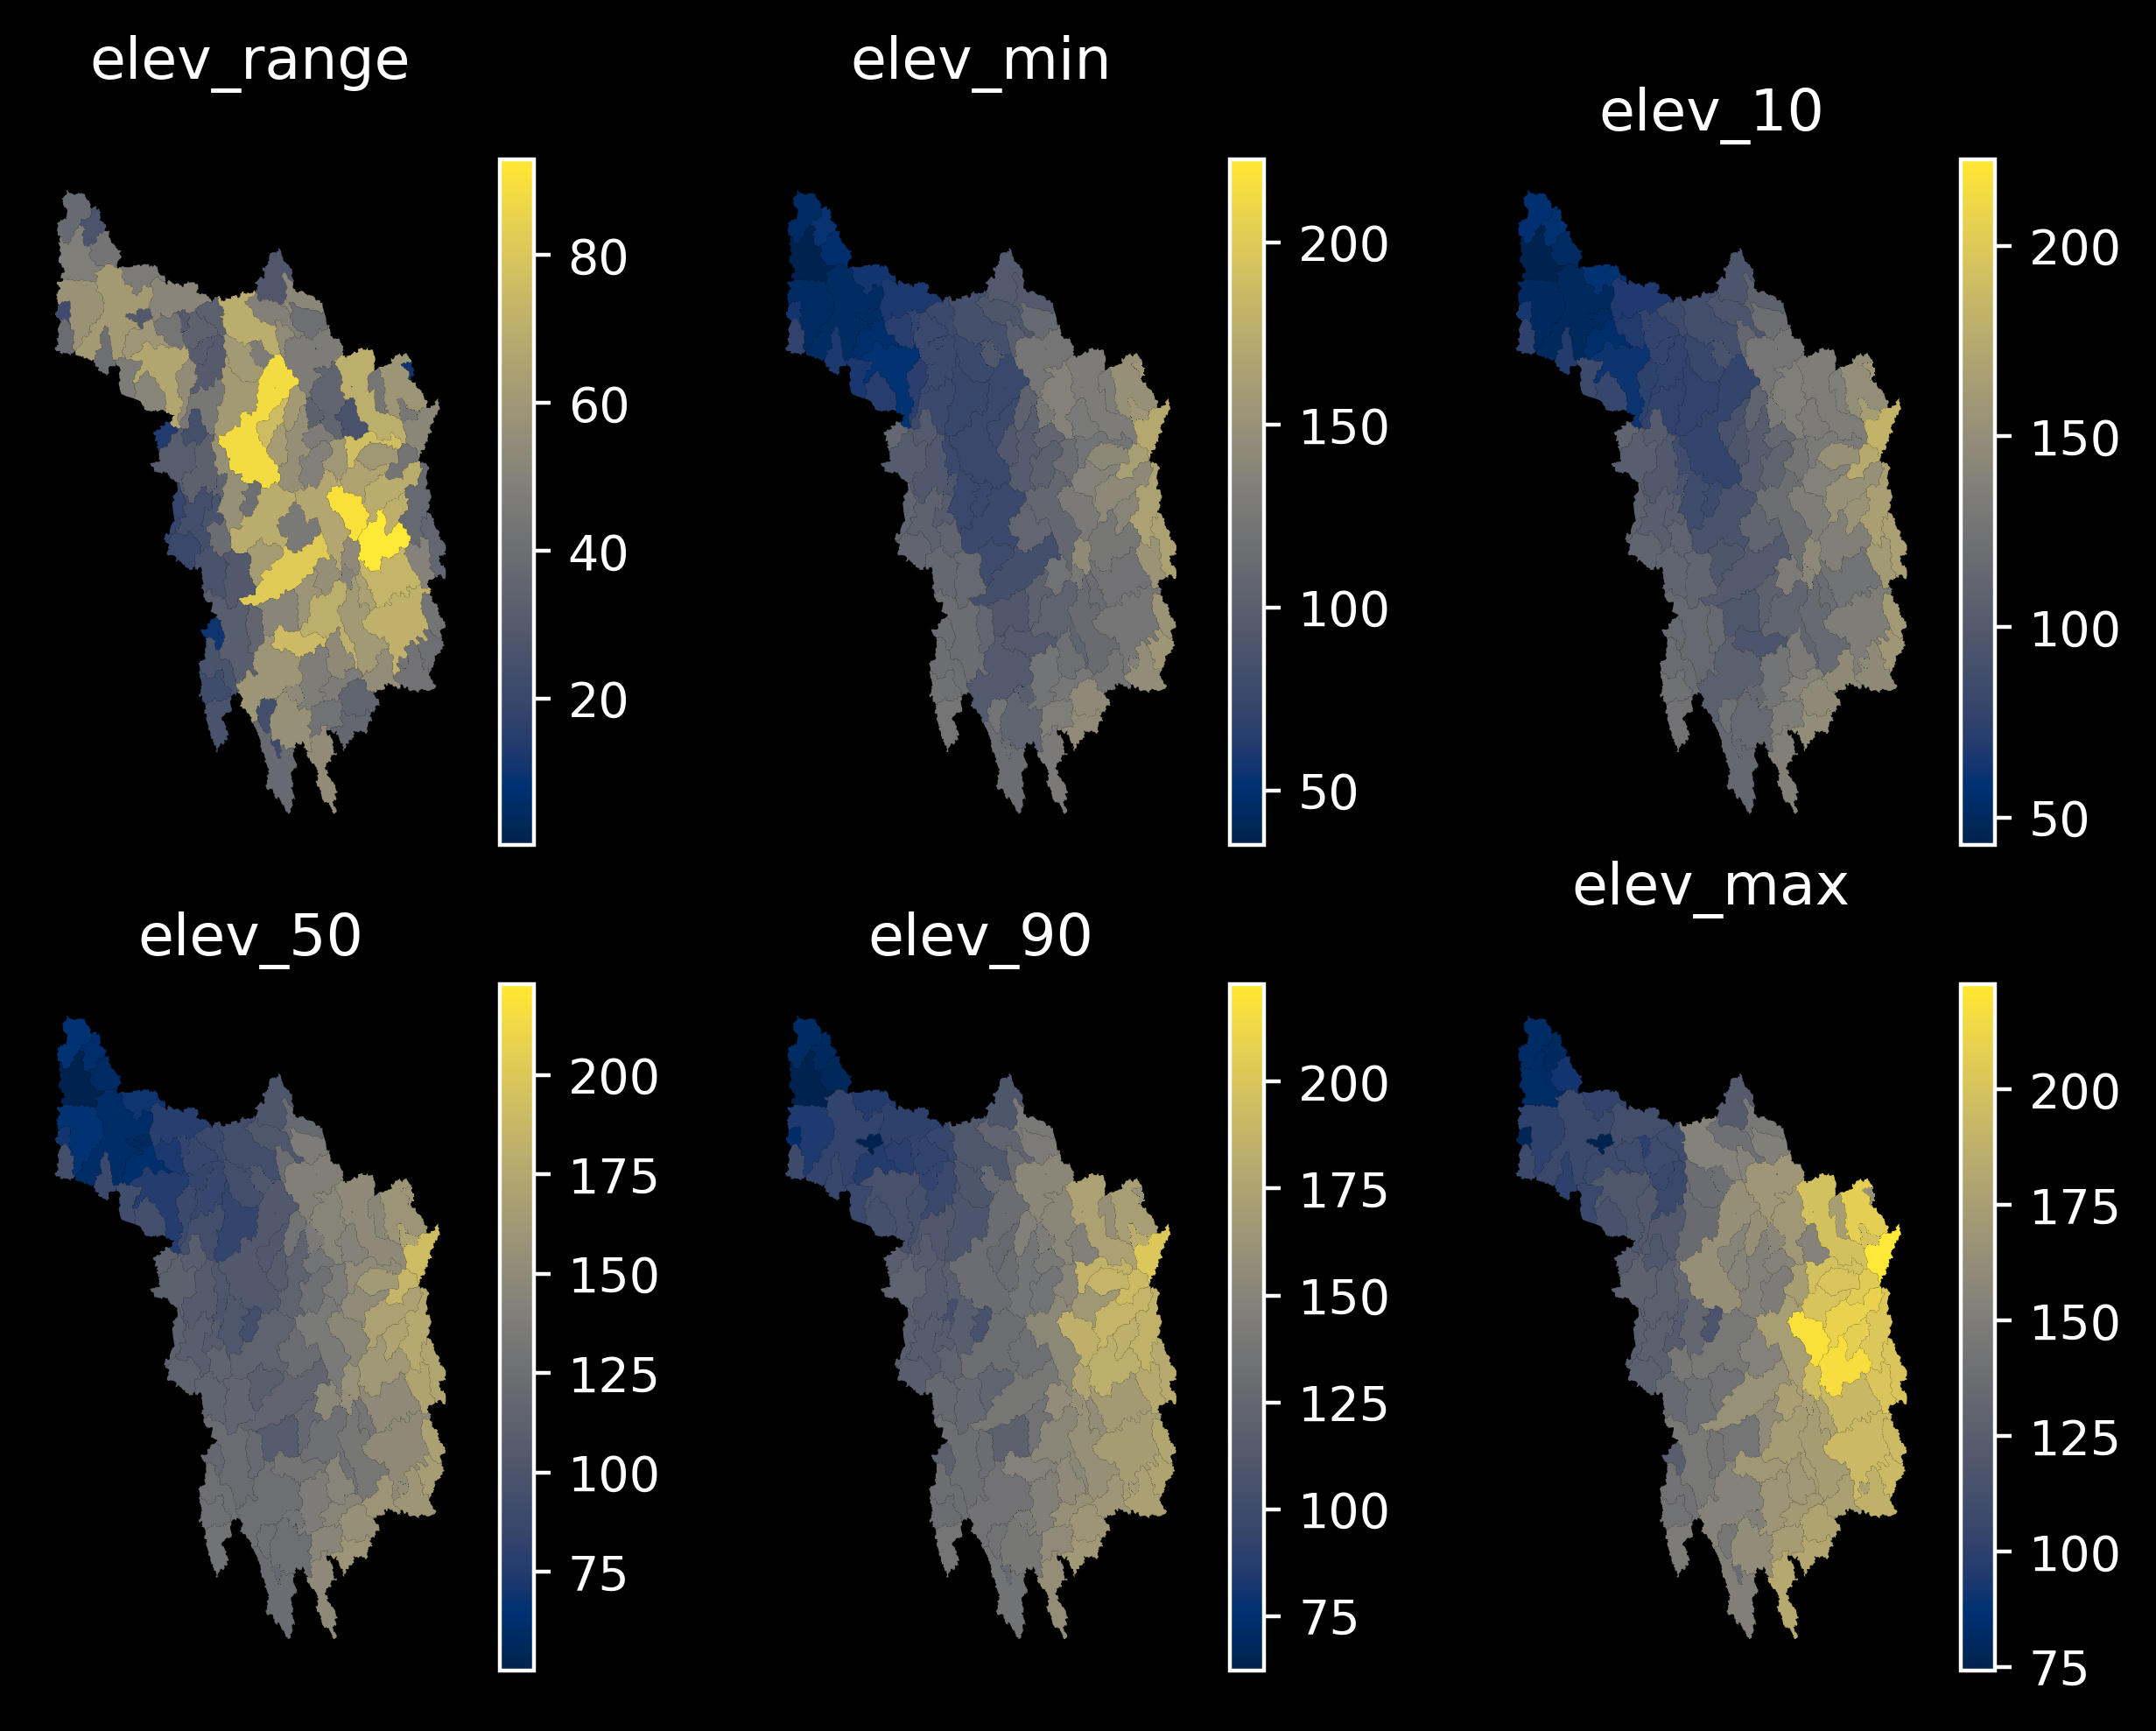

In [46]:
fig, axs = plt.subplots(2, 3)

vmax=subwatersheds['elev_max'].max()
columns = ['elev_range', 'elev_min', 'elev_10', 'elev_50', 'elev_90', 'elev_max']

for column, ax in zip(columns, axs.ravel()):
    if column == 'elev_range':
        ax = subwatersheds.plot(column, ax=ax, markersize=0.2, cmap='cividis', legend=True)
    else:
        ax = subwatersheds.plot(column, ax=ax, markersize=0.2, vmax=vmax, cmap='cividis', legend=True)
    ax.set_axis_off()
    ax.set_title(column)
plt.tight_layout(pad=0.2)

<Axes: >

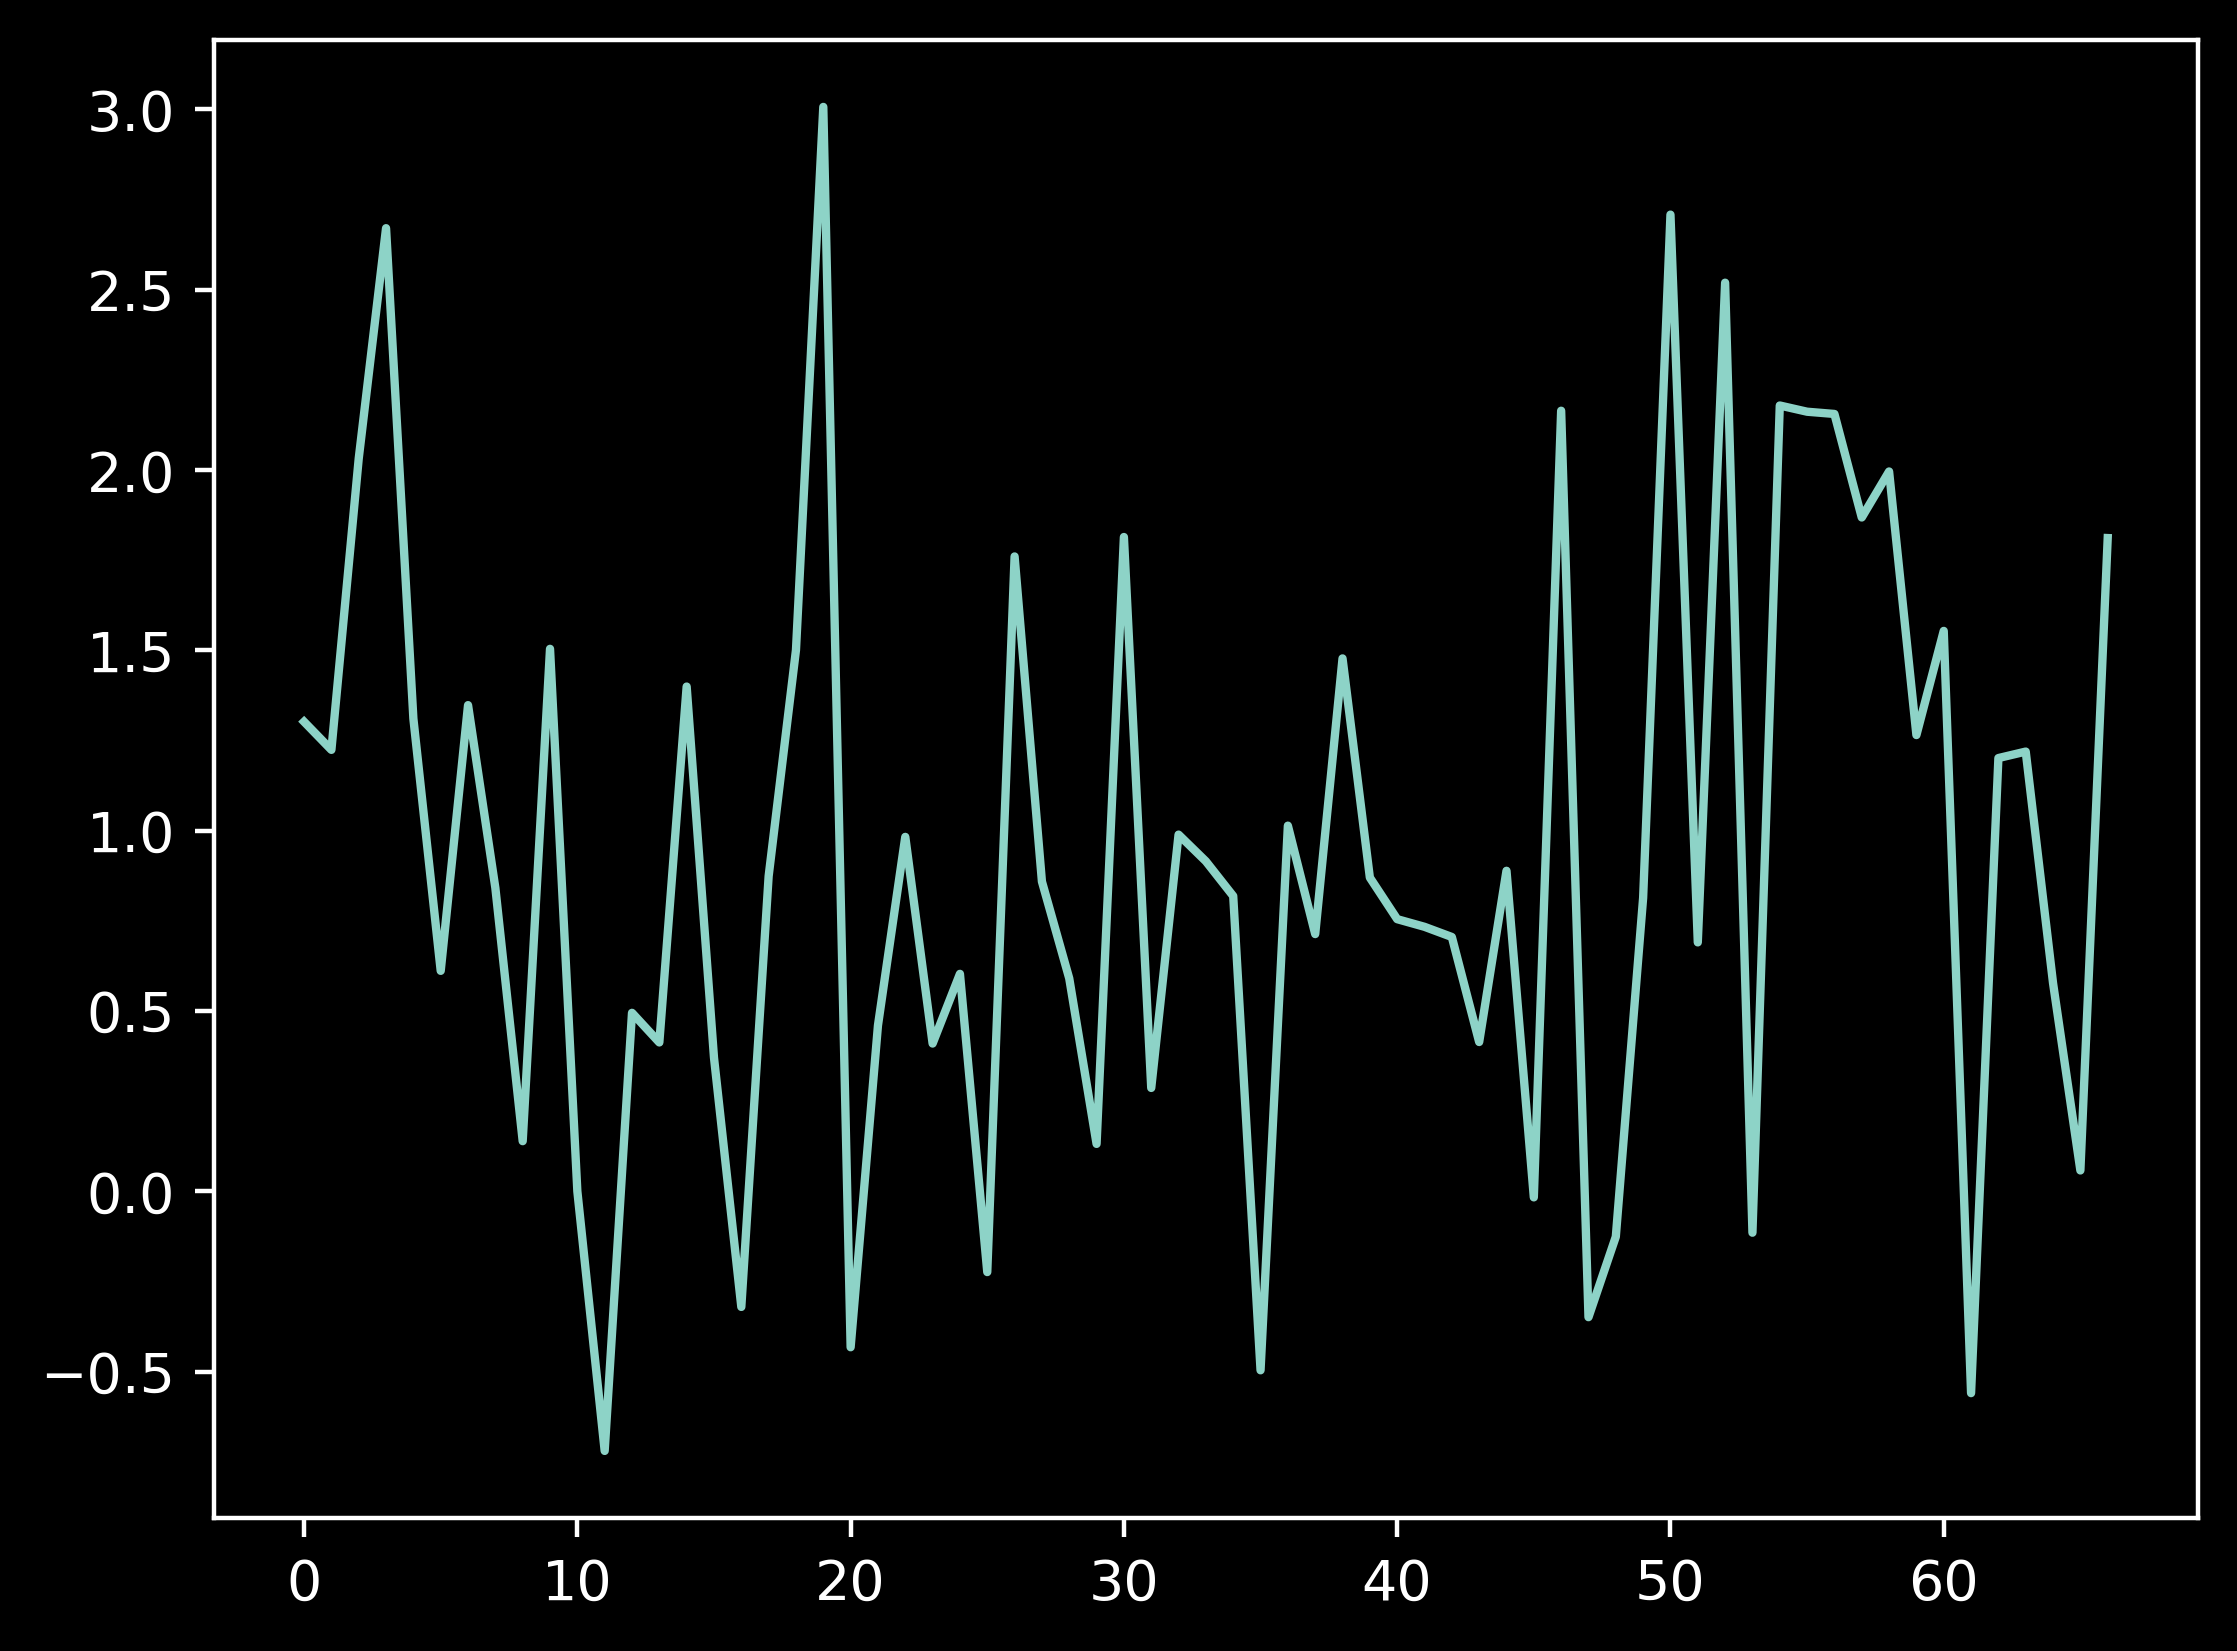

In [30]:
(subwatersheds['elev_mean'] - subwatersheds['elev_50']).plot()

In [14]:
subwatersheds

Paikka_Id  main_basin_index     area_m2   id     pituus_m  next   pour  \
0       1117                14   4938400.0   48  3993.853186   140  False   
1       1117                14   2351600.0   46  3185.227270   140  False   
2       1117                14  28843300.0  140  3998.361541   142  False   
3       1117                14   4960700.0  142  3348.295435   124  False   
4       1117                14   5314800.0   30  7145.367263    24  False   
..       ...               ...         ...  ...          ...   ...    ...   
62      1117                14   8677700.0   52  5975.484245   146  False   
63      1117                14  32535400.0  146  2035.280030    74  False   
64      1117                14  17599100.0   70    10.710392    71  False   
65      1117                14       800.0   62  2610.791934    64  False   
66      1117                14   9074800.0   64  5612.439707    70  False   

      dam  in_connect   lake  ...  peat_portion  soil_depth   slope  \
0   False           0  False  ...        0.2068     62.2038  1.3319   
1   False           0  False  ...        0.0460     11.0600  2.2253   
2   False           2  False  ...        0.0707     38.3245  1.6620   
3   False           1  False  ...        0.1453     17.2945  2.4570   
4   False           0  False  ...        0.3635      9.6446  1.8466   
..    ...         ...    ...  ...           ...         ...     ...   
62  False           0  False  ...        0.0316      6.8989  4.0422   
63  False           3  False  ...        0.0061      8.3647  4.5177   
64   True           2  False  ...        0.0000      9.4473  4.4993   
65  False           0  False  ...        0.0000      0.0000  2.5315   
66  False           1  False  ...        0.0000     11.2650  3.8666   

                                             geometry  elev_mean  elev_min  \
0   POLYGON ((267820 6758350, 267820 6758320, 2677...        NaN       NaN   
1   POLYGON ((263400 6756500, 263400 6756490, 2633...        NaN       NaN   
2   POLYGON ((266640 6760950, 266640 6760940, 2666...        NaN       NaN   
3   POLYGON ((264710 6753050, 264710 6753040, 2646...        NaN       NaN   
4   POLYGON ((258090 6752280, 258090 6752270, 2580...        NaN       NaN   
..                                                ...        ...       ...   
62  POLYGON ((254000 6715230, 254000 6715190, 2539...        NaN       NaN   
63  POLYGON ((256700 6718610, 256700 6718600, 2566...        NaN       NaN   
64  POLYGON ((245860 6717920, 245860 6717910, 2458...        NaN       NaN   
65  POLYGON ((243540 6709370, 243540 6709360, 2435...        NaN       NaN   
66  POLYGON ((241880 6711070, 241880 6711060, 2418...        NaN       NaN   

      elev_10    elev_50    elev_90  elev_max  
0   74.894297  83.050003  97.152000       NaN  
1   72.567001  74.723999  81.039501       NaN  
2   72.375999  76.522003  87.563004       NaN  
3   66.802002  71.759003  86.421600       NaN  
4   70.252998  73.560497  81.864998       NaN  
..        ...        ...        ...       ...  
62  26.589600  39.389000  54.362000       NaN  
63  20.656000  33.353001  51.105000       NaN  
64  14.309000  27.459999  44.109001       NaN  
65  19.288000  19.809999  20.574700       NaN  
66  18.794001  26.621500  41.948602       NaN  

[67 rows x 46 columns]

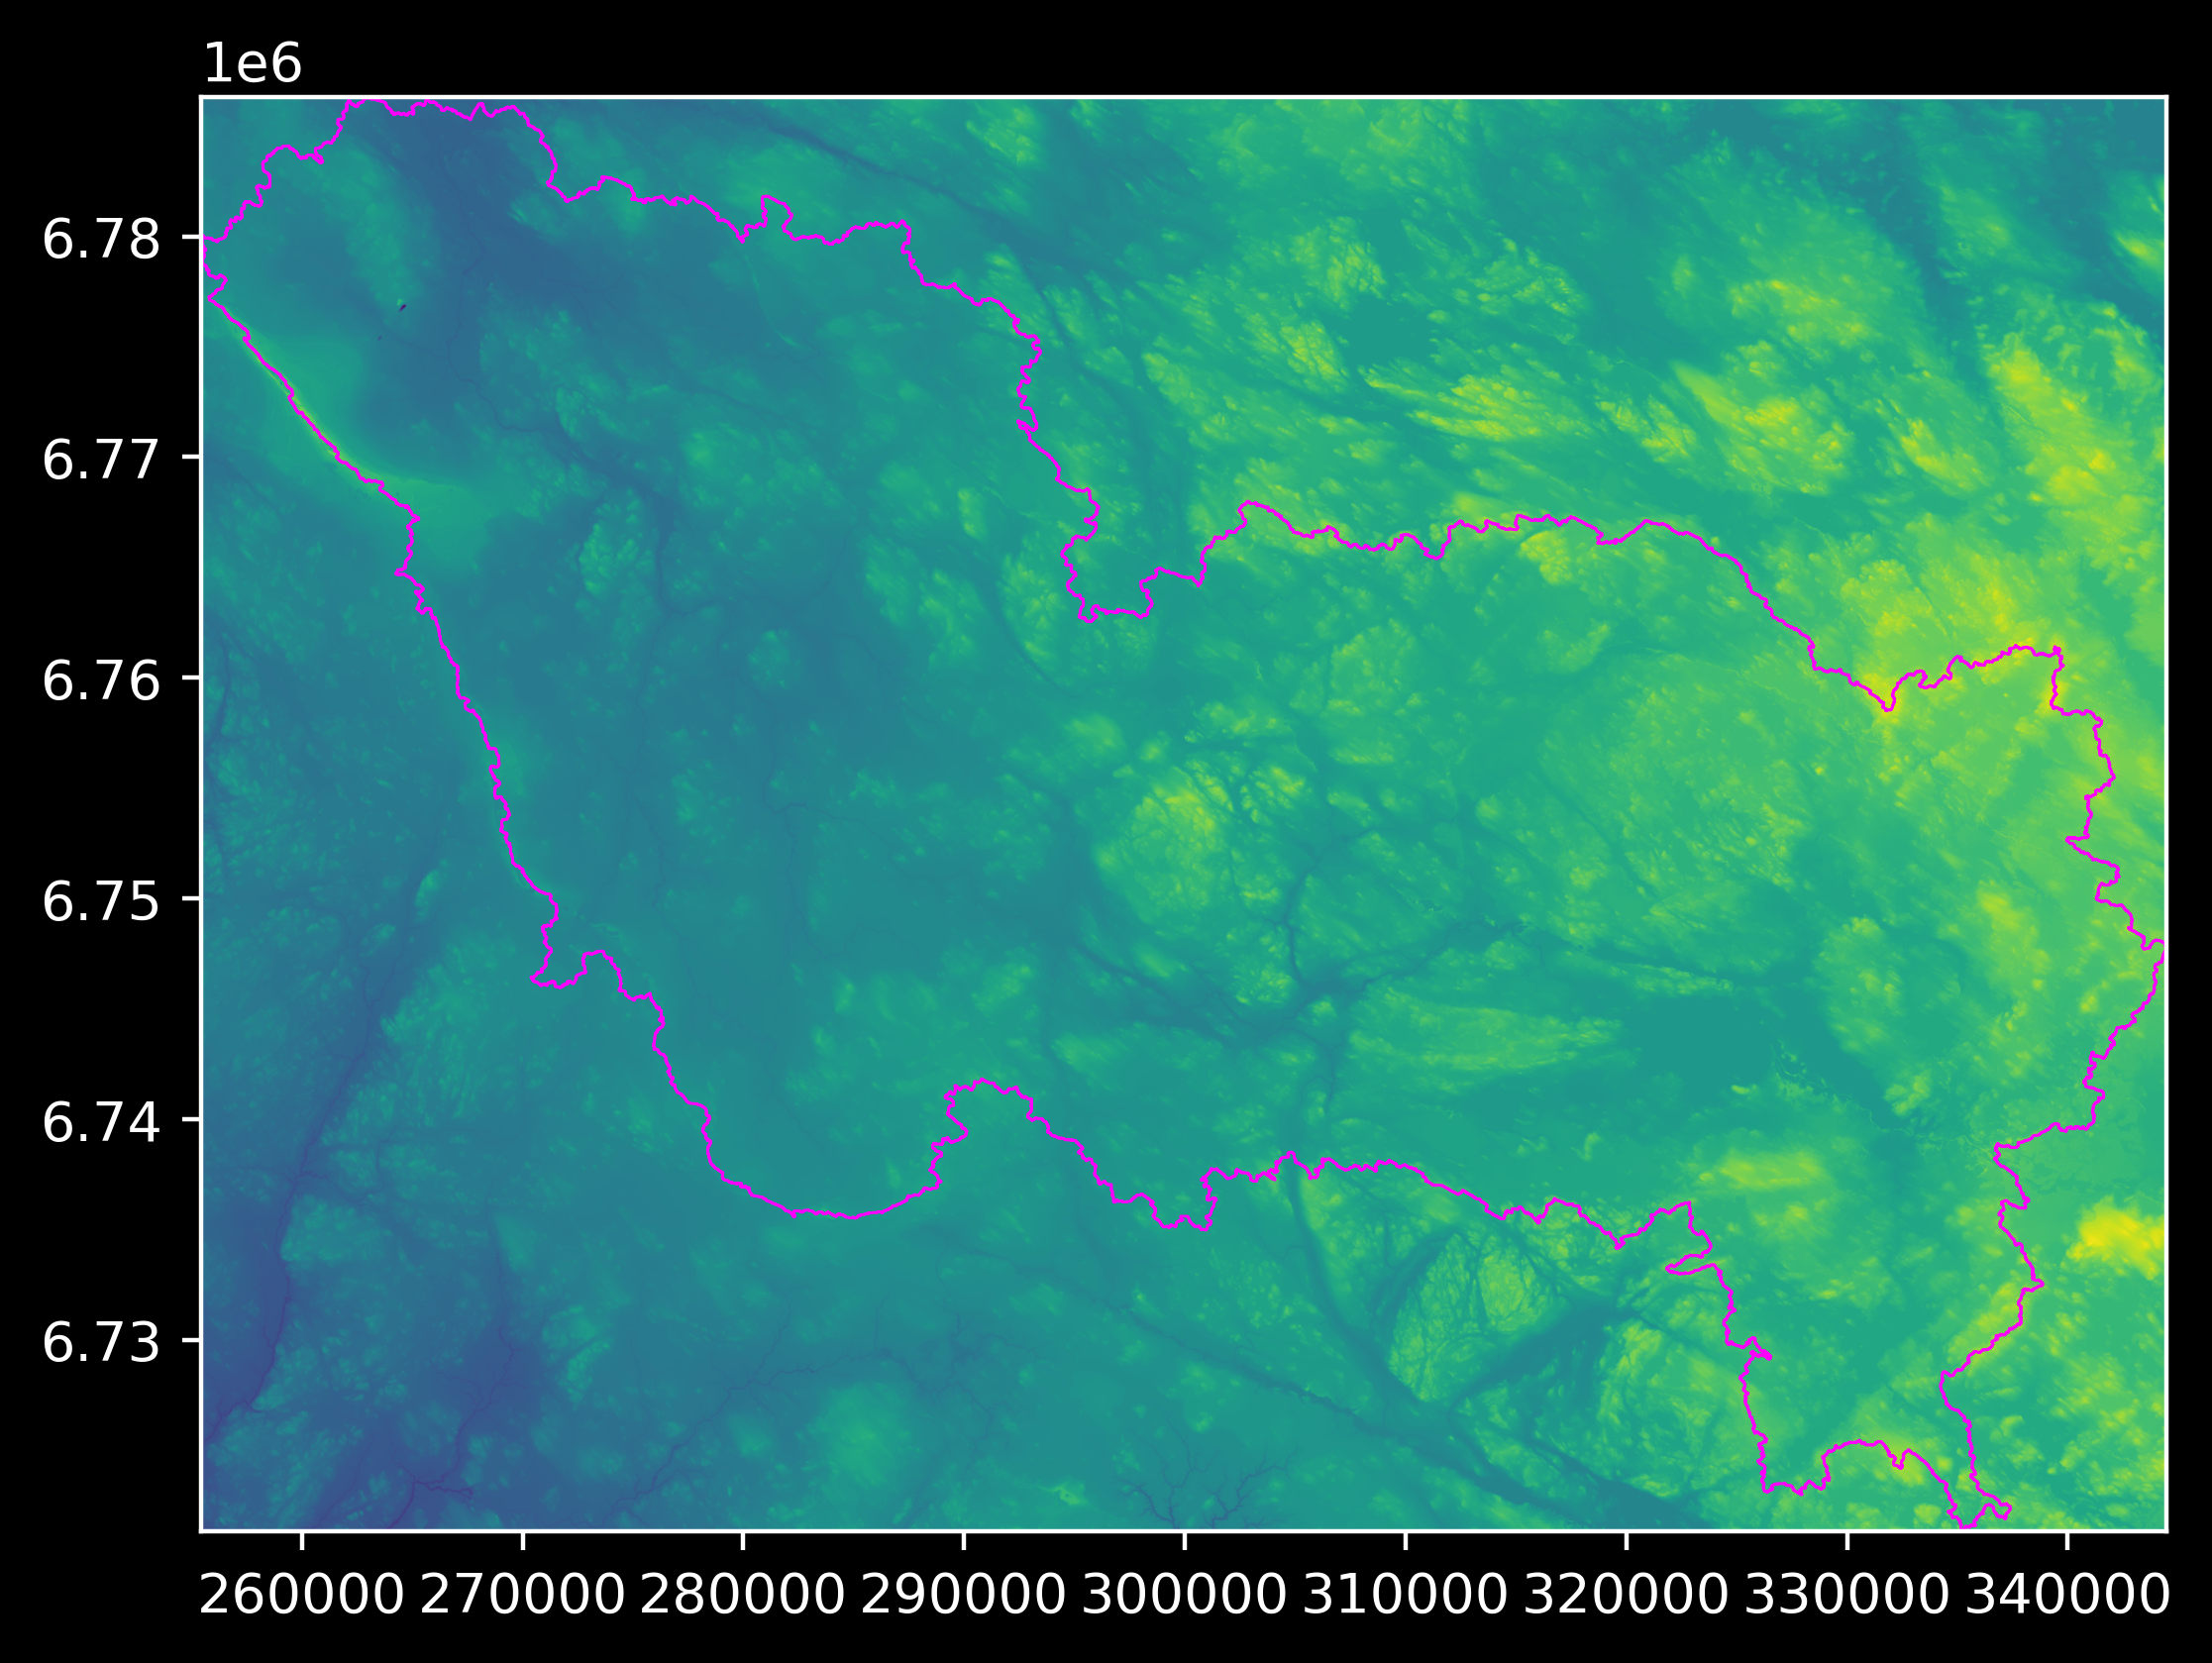

In [44]:
minx = watershed.bounds.at[0, 'minx']
miny = watershed.bounds.at[0, 'miny']
maxx = watershed.bounds.at[0, 'maxx']
maxy = watershed.bounds.at[0, 'maxy']

with rasterio.open(dem_path) as src:
    profile = src.profile
    values = src.read(
        1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
        boundless=True, fill_value=profile['nodata'])
    
profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
profile['width'] = values.shape[1]
profile['height'] = values.shape[0]
# For visualization
masked_values = ma.masked_values(values, profile['nodata'])
    



fig, ax = plt.subplots()
show(masked_values, transform=profile['transform'], ax=ax)
#show(class_values, transform=profile['transform'], ax=ax, interpolation='none', cmap='cividis')
#show(clipped_values, transform=profile['transform'], ax=ax, interpolation='none', cmap='cividis')
ax = watershed.boundary.plot(ax=ax, color='fuchsia', linewidth=0.5)

IndexError: index 5 is out of bounds for axis 0 with size 2

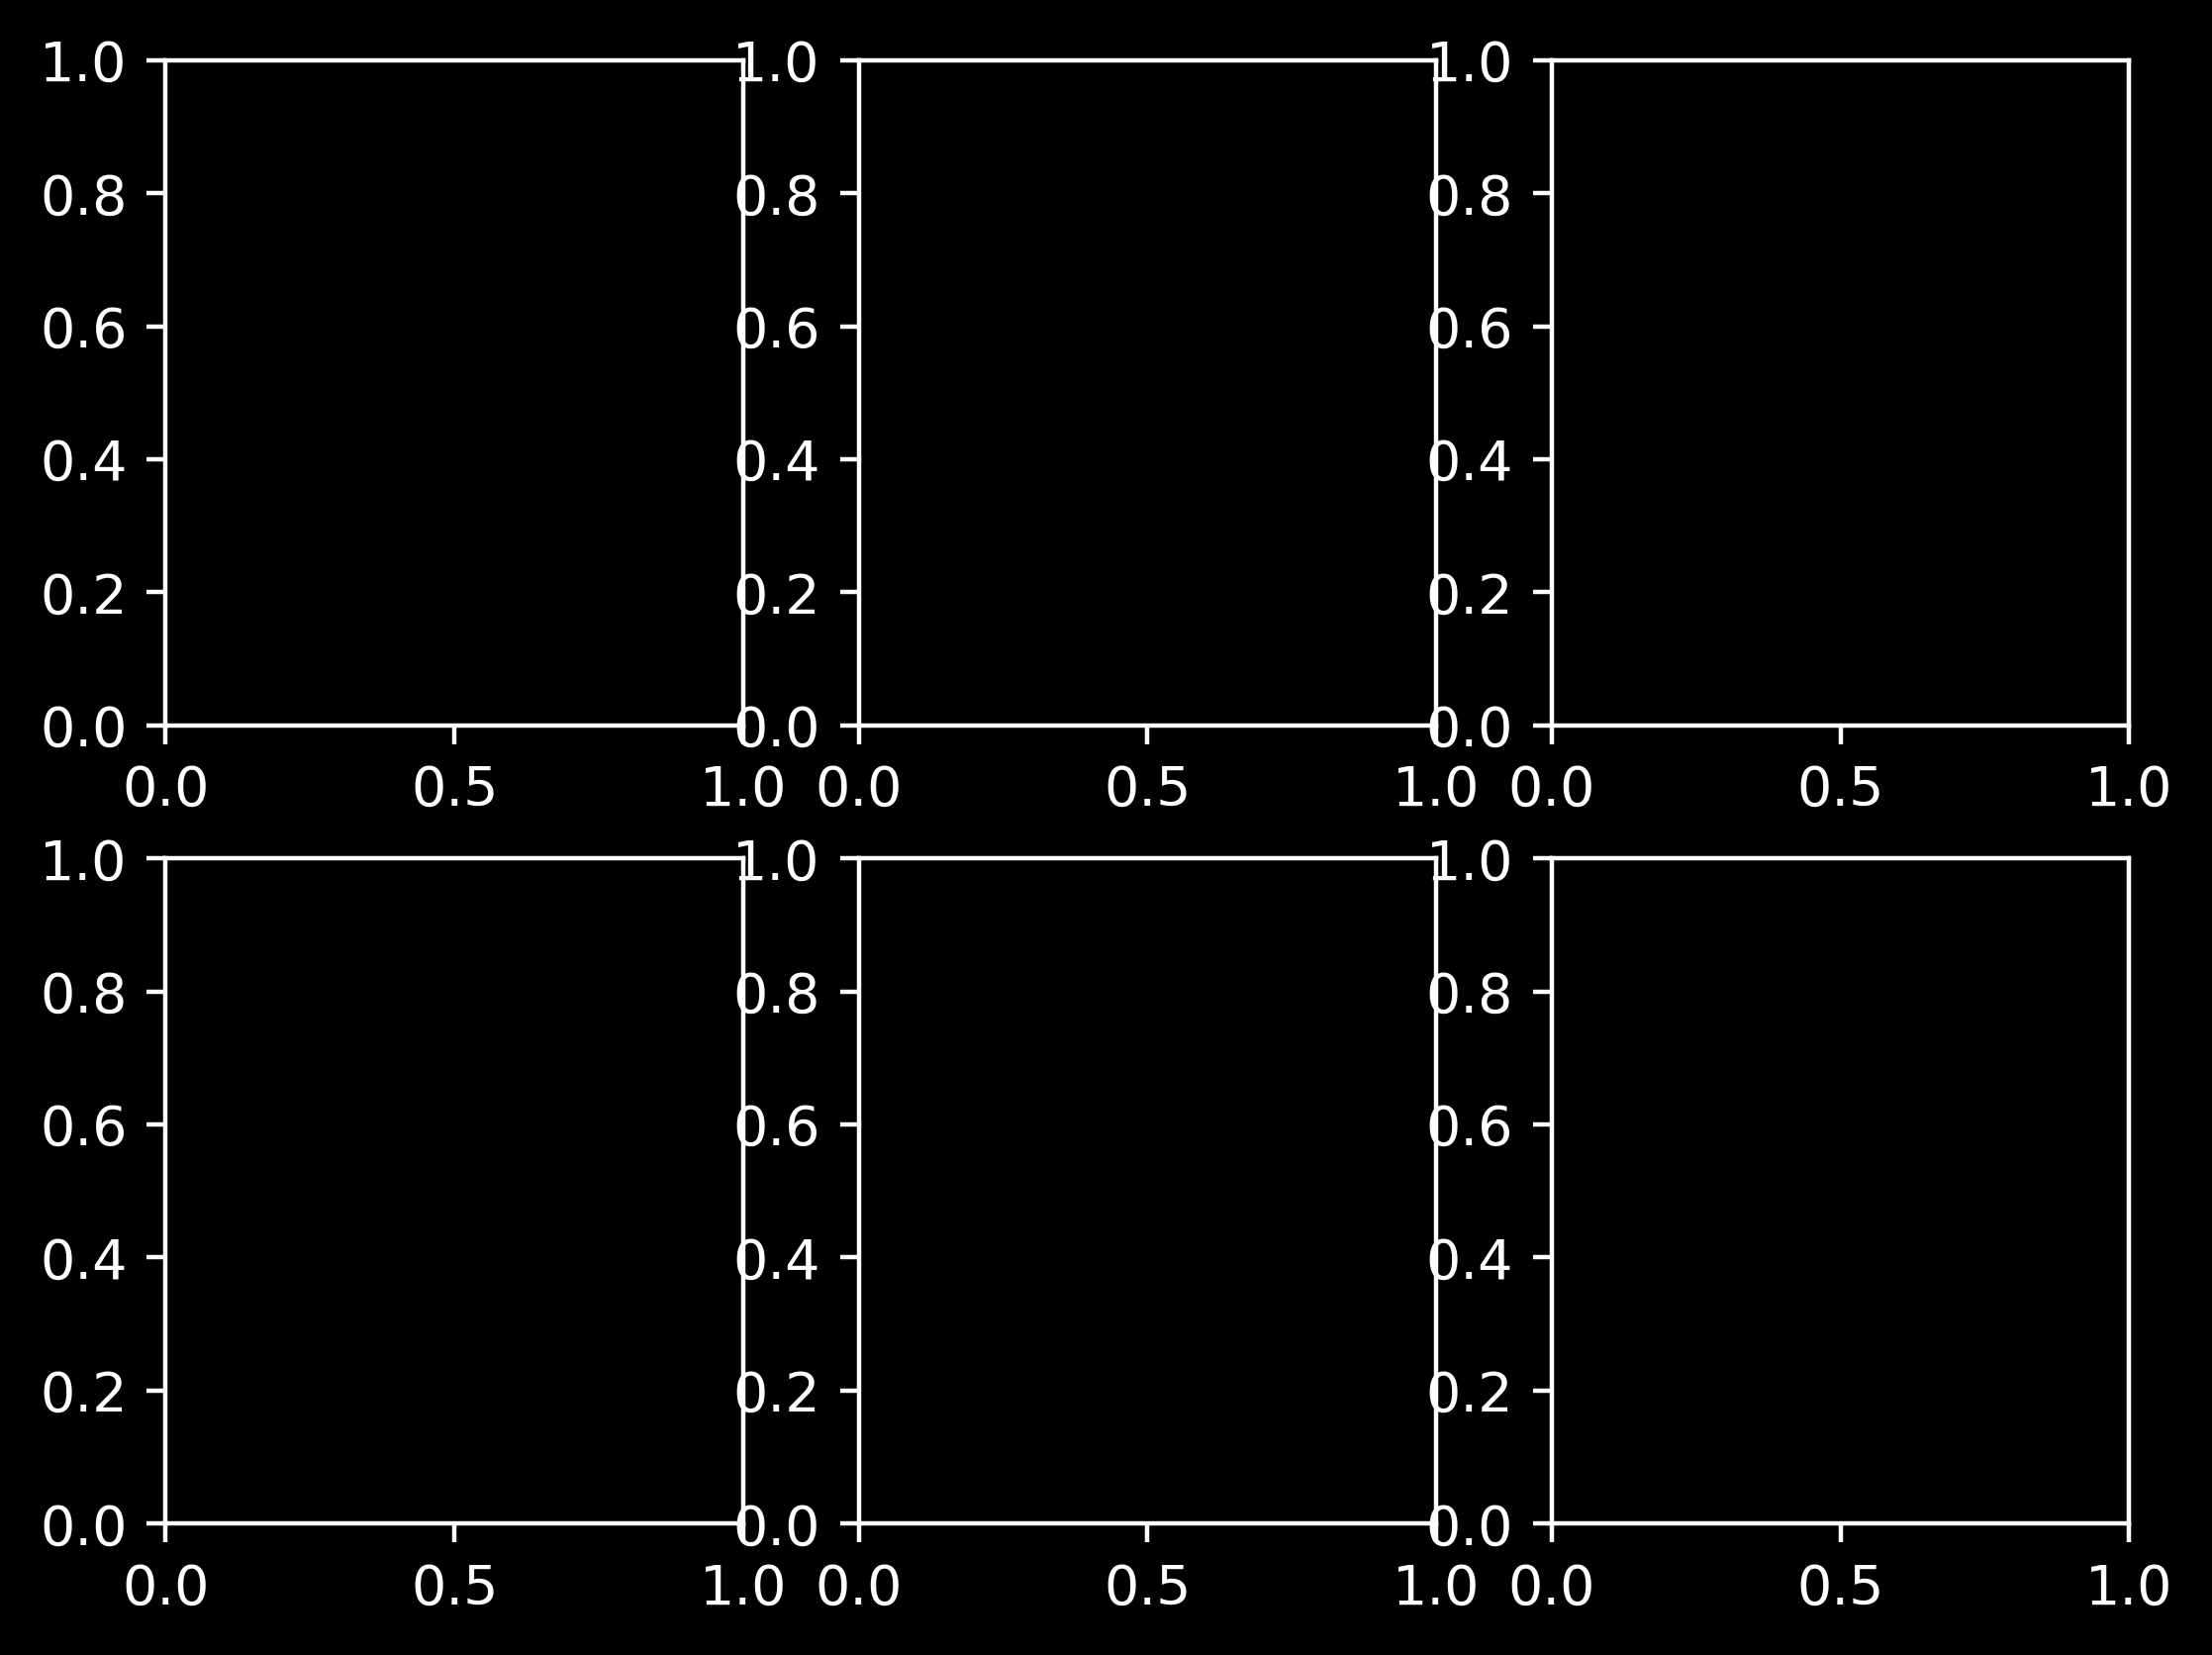

In [25]:
fig, axs = plt.subplots(2, 3)